In [1]:
%load_ext autoreload
%autoreload 2

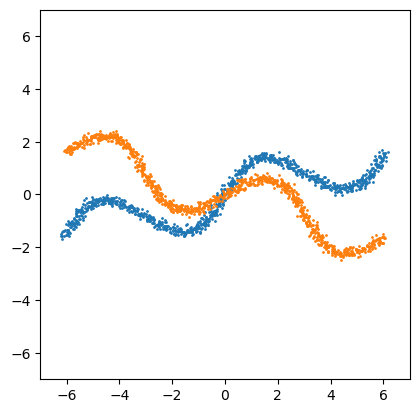

In [23]:
"""
generate toy_sin data
"""
import matplotlib.pyplot as plt
import numpy as np
import torch

z0 = np.linspace(-2*np.pi, 2*np.pi, 1000)
z1 = np.sin(z0)
z = np.concatenate((z0[:, None], z1[:, None]), axis=1)

theta_a = np.pi / 12.
theta_b = np.pi / -12.
T_a = np.array([[np.cos(theta_a), -np.sin(theta_a)],
                [np.sin(theta_a), np.cos(theta_a)]])
T_b = np.array([[np.cos(theta_b), -np.sin(theta_b)],
                [np.sin(theta_b), np.cos(theta_b)]])
x_a = torch.as_tensor(z @ T_a.T)
x_b = torch.as_tensor(z @ T_b.T)

x_a = x_a + 0.1 * torch.randn_like(x_a)
x_b = x_b + 0.1 * torch.randn_like(x_b)

plt.scatter(x_a[:, 0], x_a[:, 1], s=1)
plt.scatter(x_b[:, 0], x_b[:, 1], s=1)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.draw()

data = {
    'x_a': x_a,
    'x_b': x_b,
}
# torch.save(data, './data/toy_sin/data.pt')

2


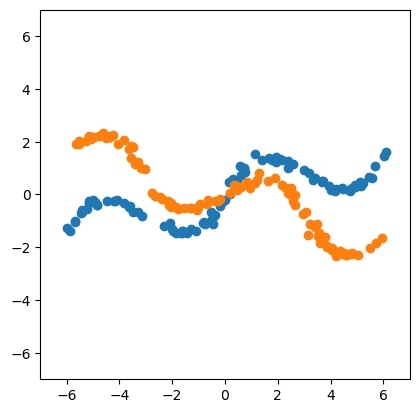

In [46]:
"""
test dataloader for toy_sin data
"""
import os
import torch
from torch.utils.data import DataLoader
from dataloader.toy_sin import toy_sin_pair, toy_sin_a, toy_sin_b


train_data = toy_sin_pair()
tr = DataLoader(train_data, 100, shuffle=True)
x = next(iter(tr))[0]
print(len(x))

if len(x) == 2:
    xa, xb = x
    plt.scatter(xa[:, 0], xa[:, 1])
    plt.scatter(xb[:, 0], xb[:, 1])
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.draw()
elif len(x) == 1:
    plt.scatter(x[0][:, 0], x[0][:, 1])
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.draw()

In [3]:
import torch

from utils.misc import load_nefnet, load_scorenet, requires_grad
from sampler import euler_sampler, sum_sampler
import matplotlib.pyplot as plt

nef_state = torch.load('ckpt/nef_toy_sin_pair.pt', map_location='cpu')
score_a_state = torch.load('ckpt/score_toy_sin_a.pt', map_location='cpu')
score_b_state = torch.load('ckpt/score_toy_sin_b.pt', map_location='cpu')

eigenvalue, nef = load_nefnet('ckpt/nef_toy_sin_pair.pt')
score_a = load_scorenet('ckpt/score_toy_sin_a.pt')
score_b = load_scorenet('ckpt/score_toy_sin_b.pt')

requires_grad(nef, False)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

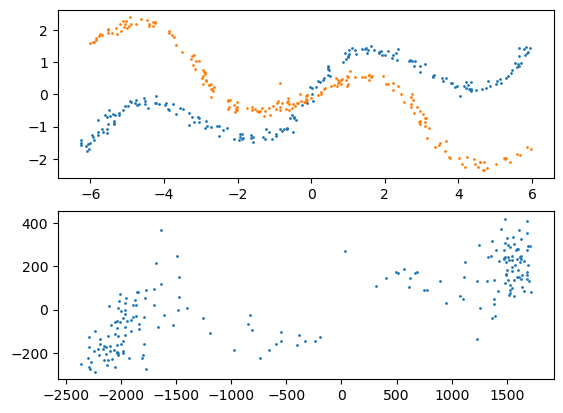

In [23]:
xa = euler_sampler(score_a, torch.randn((200, 2)))
xb = euler_sampler(score_b, torch.randn((200, 2)))
xp = sum_sampler(score_a, score_b, torch.randn((200, 2)))
plt.subplot(211)
plt.scatter(xa[:, 0], xa[:, 1], s=1)
plt.scatter(xb[:, 0], xb[:, 1], s=1)
plt.subplot(212)
plt.scatter(xp[:, 0], xp[:, 1], s=1)


In [47]:
from model.kernel import evaluate_kernel, kernel_score
from dataloader.toy_sin import toy_sin_pair, toy_sin_a, toy_sin_b
from torch.utils.data import DataLoader


train_data = toy_sin_pair()
tr = DataLoader(train_data, 4, shuffle=True)
x = next(iter(tr))[0]
x1 = x[0].float()
x2 = x[1].float()



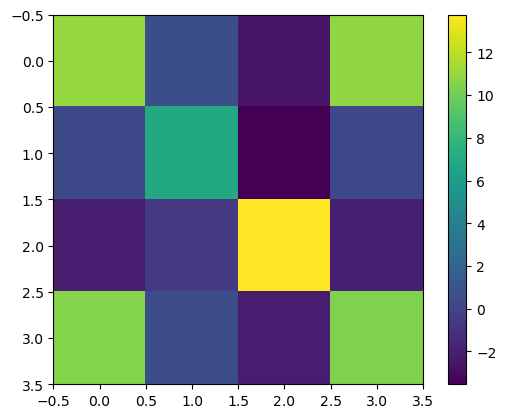

In [48]:
K = evaluate_kernel(nef, eigenvalue, x1, x2).detach().cpu()
plt.imshow(K)
plt.colorbar()

In [50]:
nef(x1)[1]

tensor([ 1.0670,  1.4165,  0.1213, -1.3477,  1.3609, -0.1492,  1.3100, -0.1262],
       grad_fn=<SelectBackward0>)

In [21]:
from sampler import pair_euler_sampler
s1, s2 = pair_euler_sampler(nef, eigenvalue, score_a, score_b, torch.randn((200, 2)), torch.randn((200, 2)), num_steps=100)

  0%|          | 0/1500 [00:00<?, ?it/s]

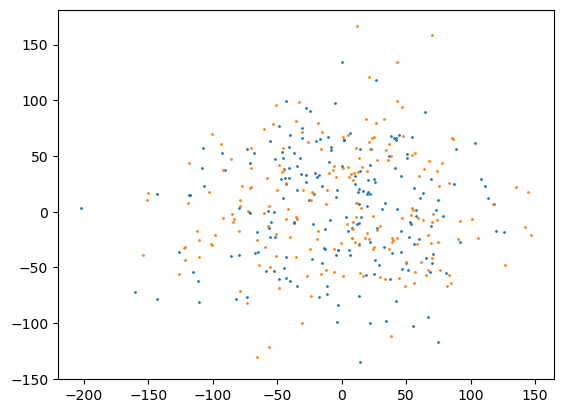

In [22]:
plt.scatter(s1[:, 0], s1[:, 1], s=1)
plt.scatter(s2[:, 0], s2[:, 1], s=1)

tensor([[ 1.5200, -0.7800,  0.8000,  0.8000],
        [-0.7800,  4.2800,  0.8000,  0.8000],
        [ 0.8000,  0.8000,  1.0600,  1.3300],
        [ 0.8000,  0.8000,  1.3300,  2.1800]])
tensor([2.4116e+00, 4.7987e-01, 2.9931e-06, 7.3035e-02, 1.1843e+00, 7.6163e-02,
        6.1289e-04, 1.4230e-05, 1.5410e+00, 8.4867e-01])
tensor([1.4552e-39])


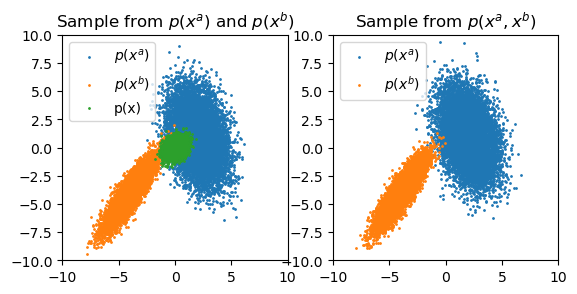

In [231]:
import numpy as np
import torch.distributions as td

def get_distribution_and_samples():
    mu_x = torch.zeros((2,), dtype=torch.float32)
    cov_x = .2*torch.as_tensor([[1, 0.3], 
                            [0.3, 1]])
    px = td.MultivariateNormal(mu_x, cov_x)
    sample_x = px.sample((10000,))
    # --------------------------------------------------------------------
    A = torch.as_tensor([[-2, 2],
                        [4, 1]], dtype=torch.float32)
    m = torch.as_tensor([2, 1])
    L_a = .2*torch.as_tensor([[2., .3], 
                            [.3, 2.]])
    mu_a = A @ mu_x + m
    Sigma_a = L_a + A @ cov_x @ A.T
    pa = td.MultivariateNormal(mu_a, Sigma_a)
    sample_a = pa.sample((10000,))
    # --------------------------------------------------------------------
    B = torch.as_tensor([[-2, 1],
                        [-3, 2]], dtype=torch.float32)
    n = torch.as_tensor([-4, -4])
    L_b = .3*torch.as_tensor([[1, 0.5], 
                            [0.5, 1]])
    mu_b = B @ mu_x + n
    Sigma_b = L_b + B @ cov_x @ B.T
    pb = td.MultivariateNormal(mu_b, Sigma_b)
    sample_b = pb.sample((10000,))
    # --------------------------------------------------------------------
    C = torch.zeros((4, 4))
    d = torch.zeros((4,))
    L_c = .8*torch.ones((4, 4))
    mu_X = torch.zeros((4,))
    cov_X = torch.zeros((4, 4))
    C[:2, :2] = A
    C[-2:, -2:] = B
    d[:2] = m
    d[2:] = n
    L_c[:2, :2] = L_a
    L_c[-2:, -2:] = L_b
    mu_X[:2] = mu_x
    mu_X[2:] = mu_x
    cov_X[:2, :2] = cov_x
    cov_X[-2:, -2:] = cov_x

    mu_c = C @ mu_X + d
    Sigma_c = L_c + C @ cov_X @ C.T
    pab = td.MultivariateNormal(mu_c, Sigma_c)
    sample_ab = pab.sample((10000,))
    print(Sigma_c)

    return px, pa, pb, pab, sample_x, sample_a, sample_b, sample_ab

def plot_all_samples(sample_x, sample_a, sample_b, sample_c):
    fig, axes = plt.subplots(1, 2)
    la = axes[0].scatter(sample_a[:, 0], sample_a[:, 1], s=1)
    lb = axes[0].scatter(sample_b[:, 0], sample_b[:, 1], s=1)
    lx = axes[0].scatter(sample_x[:, 0], sample_x[:, 1], s=1)
    axes[0].set_xlim(-10, 10)
    axes[0].set_ylim(-10, 10)
    axes[0].set_aspect('equal', adjustable='box')
    axes[0].legend((la, lb, lx), ('$p(x^a)$', '$p(x^b)$', 'p(x)'))
    axes[0].set_title('Sample from $p(x^a)$ and $p(x^b)$')
    la = axes[1].scatter(sample_c[:, 0], sample_c[:, 1], s=1)
    lb = axes[1].scatter(sample_c[:, 2], sample_c[:, 3], s=1)
    axes[1].set_xlim(-10, 10)
    axes[1].set_ylim(-10, 10)
    axes[1].set_aspect('equal', adjustable='box')
    axes[1].legend((la, lb), ('$p(x^a)$', '$p(x^b)$'))
    axes[1].set_title('Sample from $p(x^a, x^b)$')
    

def evaluate_kernel(x1, x2, pa, pb, pab):
    logk = pab.log_prob(torch.cat((x1, x2), dim=1)) - pa.log_prob(x1) - pb.log_prob(x2)
    return logk.exp()
    
    
px, pa, pb, pab, sample_x, sample_a, sample_b, sample_ab = get_distribution_and_samples()
plot_all_samples(sample_x, sample_a, sample_b, sample_ab)
rand1 = torch.randn((2,)).unsqueeze(0)
rand2 = torch.randn((2,)).unsqueeze(0)
test_a = pa.sample((10,))
test_b = pb.sample((10,))
print(evaluate_kernel(test_a, test_b, pa, pb, pab))
print(evaluate_kernel(rand1, rand2, pa, pb, pab))


